In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../..")

In [3]:
import numpy as np, pandas as pd

from mlsql.archiver import NewRecord, Session, delete_experiments
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from json import loads

import matplotlib.pyplot as plt

# Best Perf Vary CR

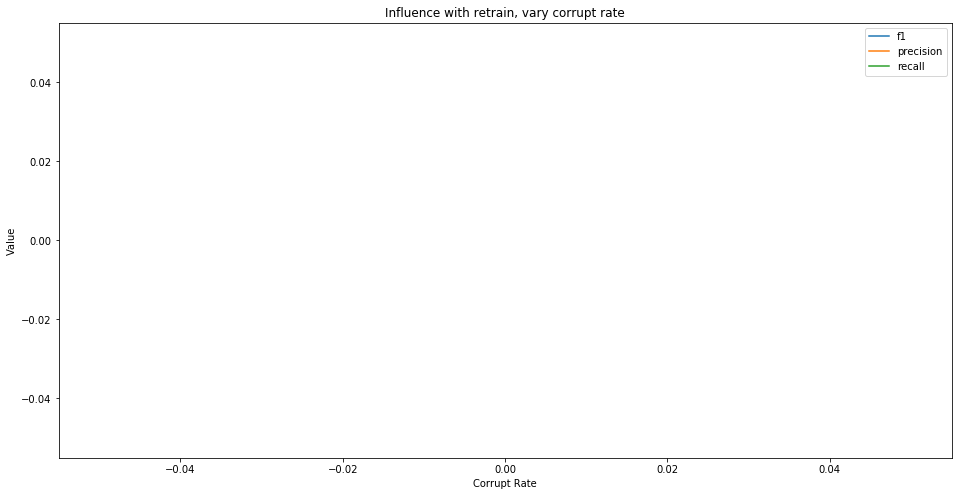

In [120]:
records = Session().query(NewRecord).filter(NewRecord.name == "DUTI-Influence-Retrain").all()
records = [record for record in records if loads(record.input)["corrupt_type"] == "positive" and loads(record.input)["rneg"] == 1]

x = np.empty(len(records))
f1s = np.empty(len(records))
precisions = np.empty(len(records))
recalls = np.empty(len(records))


for idx, r in enumerate(records):
    x[idx] = loads(r.input)["corrupt_rate"]
    tdelta = np.asarray(loads(r.output)["tdelta"])
    pdeltas = np.asarray(loads(r.output)["deltas"])
    
    subf1 = np.empty(len(pdeltas))
    for subidx in range(len(pdeltas)):
        pdelta = pdeltas[subidx, :]
        pdelta = pdelta > 0.5
        subf1[subidx] = f1_score((1 - tdelta), (1 - pdelta))
        
    maxidx = subf1.argmax()

    pdelta = pdeltas[maxidx, :] > 0.5
    
    f1s[idx] = f1_score((1 - tdelta), (1 - pdelta))
    precisions[idx] = precision_score((1 - tdelta), (1 - pdelta))
    recalls[idx] = recall_score((1 - tdelta), (1 - pdelta))

sel = x.argsort()

plt.figure(figsize=(16,8))

plt.plot(x[sel], f1s[sel], label = "f1")
plt.plot(x[sel], precisions[sel], label = "precision")
plt.plot(x[sel], recalls[sel], label = "recall")
plt.xlabel("Corrupt Rate")
plt.ylabel("Value")
plt.title("Influence with retrain, vary corrupt rate")
plt.legend()

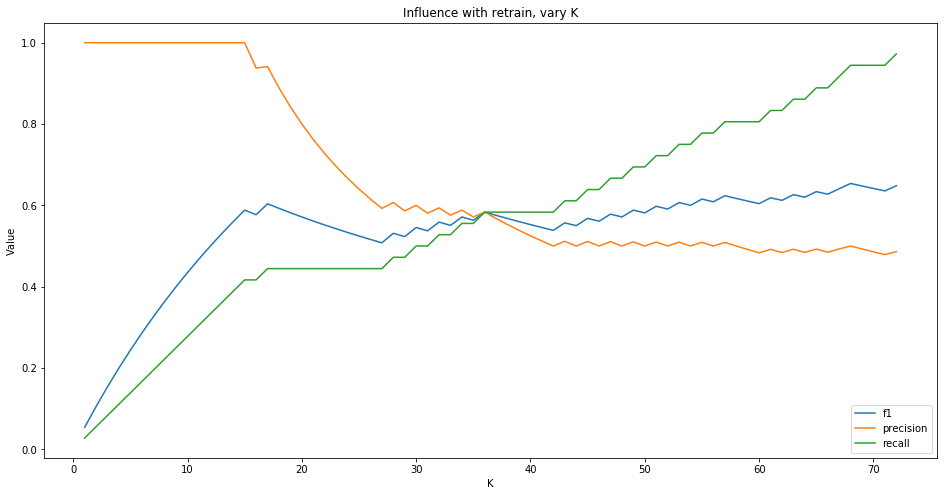

In [9]:
records = Session().query(NewRecord).filter(NewRecord.name == "DUTI-Influence-Retrain").all()
record, = [r for r in records if loads(r.input)["corrupt_type"] == "DogCatConfig.Duti"]

pdeltas = np.asarray(loads(record.output)["deltas"])
tdelta = np.asarray(loads(record.output)["tdelta"])

f1s = np.empty(len(pdeltas))
precisions = np.empty(len(pdeltas))
recalls = np.empty(len(pdeltas))

k = range(1, len(pdeltas) + 1)

for i in k:
    pdelta = pdeltas[i-1,:] > 0.5
    f1s[i-1] = f1_score((1 - tdelta), (1 - pdelta))
    precisions[i-1] = precision_score((1 - tdelta), (1 - pdelta))
    recalls[i-1] = recall_score((1 - tdelta), (1 - pdelta))

plt.figure(figsize=(16,8))

plt.plot(k, f1s, label = "f1")
plt.plot(k, precisions, label = "precision")
plt.plot(k, recalls, label = "recall")
plt.xlabel("K")
plt.ylabel("Value")
plt.title(f"Influence with retrain, vary K")
plt.legend()